In [1]:
import qutip as qt
from utils import *
import numpy as np
from IPython.display import Math,display
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qutip import ket2dm

In [2]:

# Pauli Operators
sx = 0.5*qt.operators.sigmax()
sy = 0.5*qt.operators.sigmay()
sz = 0.5*qt.operators.sigmaz()
I =  qt.operators.identity(2)

In [3]:
def hamiltonian_ising(N,omega,delta,V):
  sx = 0.5*qt.operators.sigmax()
  #sy = 0.5*qt.operators.sigmay()
  sz = 0.5*qt.operators.sigmaz()
  I = qt.operators.identity(2)

  ising_ham = qt.tensor([I*0]*N)
  for i in range(N):
    hz = qt.tensor([sz if j==i else I for j in range(N)])
    hx = qt.tensor([sx if j==i else I for j in range(N)])
    ising_ham += 1*delta*hz+omega*hx
    for j in range(i + 1, N):
        hzz = qt.tensor([sz if k == i or k == j else I for k in range(N)]) # assume obc
        ising_ham += (V/abs(i-j))*hzz
  
  return(ising_ham)

In [4]:
# Hamiltonian (of boltzmann machines)
omega = np.pi/4
N = 5
delta = 1
V =  5*omega
hamiltonian=hamiltonian_ising(N,omega,delta,V)

# jump operators 
sm = qt.operators.sigmam() # spin-lowering operators


# collapse operator
kappa = 1
c_ops = [qt.tensor([sm if i==j  else I for j in range(N)]) for i in range(N)]
c_ops = [np.sqrt(kappa/4) * c_op for c_op in c_ops]

In [5]:
hamiltonian

Quantum object: dims = [[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape = (32, 32), type = oper, isherm = True
Qobj data =
[[ 8.79954777  0.39269908  0.39269908 ...  0.          0.
   0.        ]
 [ 0.39269908  3.70893233  0.         ...  0.          0.
   0.        ]
 [ 0.39269908  0.          2.23631078 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.76368922  0.
   0.39269908]
 [ 0.          0.          0.         ...  0.          0.70893233
   0.39269908]
 [ 0.          0.          0.         ...  0.39269908  0.39269908
   3.79954777]]

In [6]:
# Linbladian
L = qt.liouvillian(hamiltonian, c_ops)
L_dag = qt.liouvillian(hamiltonian, c_ops).dag()

In [10]:
# diagonalization using qutip
val,mat = L_dag.eigenstates(sort='high',eigvals=3)
tol = 1e-8
real_vals = np.where(np.abs(val.imag)<tol,val.real,val)
real_vals = np.where(np.abs(real_vals.real)<tol,real_vals.imag,real_vals)
print('eigen values\n', real_vals)

l2indx = np.argsort(abs(real_vals))[1]
l2 = mat[l2indx].full().reshape(2**N,2**N)

eigen values
 [ 0.        +0.j         -0.11346457+0.j         -0.16982951-4.83210667j]


In [11]:
init_state = qt.tensor([qt.basis(2,0)]*N)
# init_state =  qt.rand_ket(2**N)
# init_state.dims = [[2]*N,[1]]
init_state

Quantum object: dims = [[2, 2, 2, 2, 2], [1, 1, 1, 1, 1]], shape = (32, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

In [12]:
rho_0 = ket2dm(init_state)
rho_0

Quantum object: dims = [[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape = (32, 32), type = oper, isherm = True
Qobj data =
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

In [13]:
l2mat = qt.Qobj(l2)
l2mat.dims = rho_0.dims

In [14]:
temp = l2mat*rho_0
abs(temp.tr())

0.22462664323238263

## New Approach

In [17]:
r0 = qt.steadystate(L)
r0

Quantum object: dims = [[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape = (32, 32), type = oper, isherm = True
Qobj data =
[[ 5.93669512e-06+0.00000000e+00j -2.48840251e-05-1.11095671e-05j
  -8.99923217e-06+4.04558321e-06j ... -1.04257841e-04+1.69901936e-04j
  -1.54207051e-04+2.45162322e-04j -1.14603784e-03+1.99540909e-03j]
 [-2.48840251e-05+1.11095671e-05j  1.30688330e-04+0.00000000e+00j
   2.98201469e-05-3.51832920e-05j ...  1.13925426e-04-9.11769470e-04j
   2.00143222e-04-1.35395538e-03j  1.08184467e-03-1.06805671e-02j]
 [-8.99923217e-06-4.04558321e-06j  2.98201469e-05+3.51832920e-05j
   3.11061865e-05+0.00000000e+00j ...  2.69365535e-04-1.61208647e-04j
   3.74704979e-04-2.19737648e-04j  3.03112206e-03-1.83126705e-03j]
 ...
 [-1.04257841e-04-1.69901936e-04j  1.13925426e-04+9.11769470e-04j
   2.69365535e-04+1.61208647e-04j ...  7.69809620e-03+0.00000000e+00j
   1.04771872e-02+4.16297113e-05j  8.19148348e-02-2.41026393e-03j]
 [-1.54207051e-04-2.45162322e-04j  2.00143222e-04+1.35395538e-03j
 

In [30]:
def u(phi,theta,lamda):
    u = ((1j/2)*phi*sz).expm()*((1j/2)*theta*sy).expm()*((1j/2)*lamda*sz).expm()
    return(u)

def Us(params):
    phi,theta,lamda = params[:N], params[N:2*N],params[2*N:3*N]
    gates = []
    for i in range(N):
        gates.append(u(phi[i],theta[i],lamda[i]))
    U = qt.tensor(gates)
    return U


def chi(params):
    U = Us(params)
    Udag = U.dag()
    c = abs((l2mat*U*rho_0*Udag).tr())
    #c = abs(qt.hilbert_dist(r0,U*rho_0*Udag))
    return c

epsilon = 1e-4
def cost(params):
    c = chi(params)
    return abs(c-epsilon)

In [31]:
initial_guess = np.concatenate([np.random.uniform(0, np.pi,5), np.random.uniform(0, 2*np.pi-0.001,5),np.random.uniform(0, np.pi,5)])

bounds = [(0, np.pi)] * 5 + [(0, 2 * np.pi - 0.001)] * 5 + [(0, 2*np.pi)] * 5

# Perform optimization
result = minimize(
    cost,                 # Objective function
    initial_guess,       # Initial  # Constraints
    bounds=bounds,
    method='SLSQP',
    options={'disp': True},
    tol = 1e-16
)

print("optimized parameters:",result.x)
print("overlap with L2 mode:",result.fun)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.005860564058367733
            Iterations: 70
            Function evaluations: 1104
            Gradient evaluations: 69
optimized parameters: [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 6.26096791
 6.28218531 6.28218531 6.28218531 6.26096785 0.61603729 0.05892956
 0.05138187 3.02796512 2.82757776]
overlap with L2 mode: 0.005860564058367733


In [32]:
rotation_unitary = Us(result.x)
mpe_state = rotation_unitary*init_state#*init_state.dag()*rotation_unitary
print("state orthogonal to l2 mode:",mpe_state)

state orthogonal to l2 mode: Quantum object: dims = [[2, 2, 2, 2, 2], [1, 1, 1, 1, 1]], shape = (32, 1), type = ket
Qobj data =
[[ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 1.25789475e-12+1.46133588e-12j]
 [-2.63094158e-10+2.26467279e-10j]
 [ 1.25789475e-12+1.46133588e-12j]
 [-2.63094158e-10+2.26467279e-10j]
 [-5.84534340e-09+5.03157889e-09j]
 [-9.05869095e-07-1.05237661e-06j]
 [ 1.25789475e-12+1.46133588e-12j]
 [-2.63094158e-10+2.26467279e-10j]
 [-5.84534340e-09+5.03157889e-09j]
 [-9.05869095e-07-1.05237661e-06j]
 [-5.84534340e-09+5.03157889e-09j]
 [-9.05869095e-07-1.05237661e-06j]
 [-2.01263151e-05-2.33813731e-05j]
 [ 4.20950636e-03-3.62347631e-03j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-1.18416862e-11+1.01931357e-11j]
 [-2.63094866e-10+2.26467887e-10j]
 [-4.07725418e-08-4.73667438e-08j]
 [-2.63094866e-10+2.26467887e-10j]
 [-4.07725418e-08-4.73667438e-08j]
 [-9.05871530e-07-1.05237944e-06j]
 [ 1.89466971e-04-1.63090164e-04j]
 [-2.63094866e-10+2.26467887e-10

In [33]:
# solving master equation
final_state = qt.steadystate(hamiltonian,c_ops) # steady state solution 

tlist = omega*np.linspace(0, 50,5000)
medata = qt.mesolve(hamiltonian, init_state, tlist, c_ops, []) # initial state  = |0>
qmpedata = qt.mesolve(hamiltonian, mpe_state, tlist, c_ops, [])

c:\Users\navan\anaconda3\envs\qc\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\navan\anaconda3\envs\qc\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


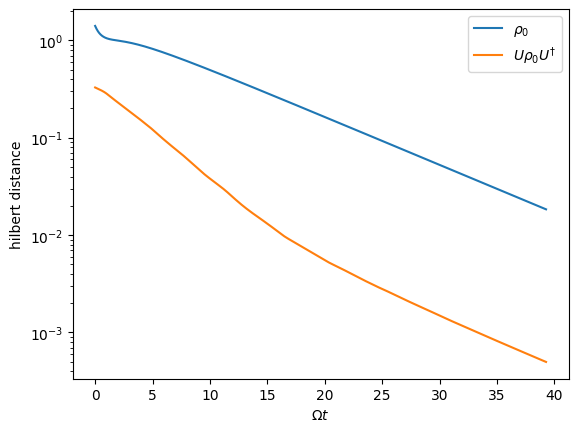

In [34]:
# calculation of Hilbert Distances

hilbert_distance = []
qmpe_dist = []

#hs_max = np.sqrt(2 *(1-1/(2**N)))

for state in medata.states:

  dis = (np.trace((state-final_state)**2))**(1/2)
  #dis=qt.hilbert_dist(state,final_state)
  hilbert_distance.append(dis)

for state in qmpedata.states:
  #dis = qt.hilbert_dist(state,final_state)
  dis = (np.trace((state-final_state)**2))**(1/2)
  qmpe_dist.append(dis)

plt.yscale('log')
plt.plot(tlist,hilbert_distance,label=r'$\rho_0$')
plt.plot(tlist,qmpe_dist,label=r'$U\rho_0U^{\dagger}$')
plt.xlabel(f'$\Omega t$')
plt.ylabel('hilbert distance')
plt.legend()
plt.show()

## Two Local Ansatz

In [134]:
ket0 = qt.ket('0')
ket1 = qt.ket('1')

In [170]:
def rx(theta):
    U =  []
    for t in theta:
        u = ((-1j/2)*t*sx).expm()
        U.append(u)
    return qt.tensor(U)

def cz(N):
    cz = qt.tensor([I,ket0,ket0.dag()])+ qt.tensor([sz,ket1,ket1.dag()])
    ucz = qt.qeye(2**N)

    for i in range(N-1):
        gates = [I]*(N-1)
        gates[i] = cz
        u = qt.tensor(gates)
        ucz.dims = [[2]*N,[2]*N]
        u.dims = [[2]*N,[2]*N]
        ucz = ucz*u
    return ucz

    
depth = 3
def two_local_unitary(params):

    thetas = np.split(params,depth)

    uansatz = np.eye(2**N,2**N)
    for i in range(depth):
        uansatz*rx(thetas[i])
        uansatz*cz(N)

    U = qt.Qobj(uansatz)
    U.dims = rho_0.dims
    return U


epsilon = 1e-4
def cost(params):
    U = two_local_unitary(params)
    Udag = U.dag()
    c = abs((l2mat*U*rho_0*Udag).tr())
    return abs(c-epsilon)

In [171]:
initial_guess = np.random.uniform(0, 2*np.pi,depth*N)

bounds = [(0, 2*np.pi)] *(depth*N)

# Perform optimization
result = minimize(
    cost,                 # Objective function
    initial_guess,       # Initial  # Constraints
    bounds=bounds,
    method='SLSQP',
    options={'disp': True},
    tol = 1e-16
)

print("optimized parameters:",result.x)
print("overlap with L2 mode:",result.fun)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.22452664323238264
            Iterations: 1
            Function evaluations: 16
            Gradient evaluations: 1
optimized parameters: [0.64839974 0.26469731 2.20666881 1.02171503 3.14913363 3.26640868
 2.31477228 3.1071832  5.5119682  2.42887943 3.61760287 1.92544186
 0.83127393 2.52262502 0.36147383]
overlap with L2 mode: 0.22452664323238264


In [ ]:
im

## Old Approach

In [181]:
def Us(theta_phi):
    phi,theta = theta_phi
    u = ((-1j/2)*phi*sz).expm()*((-1j/2)*theta*sy).expm()
    U = qt.tensor([u]*N)
    return U


def chi(theta_phi):
    # theta,phi = theta_phi
    # u = ((1j/2)*phi*sz).expm()*((1j/2)*theta*sy).expm()
    # Us = qt.tensor([u]*N)
    U = Us(theta_phi=theta_phi)
    Udag = U.dag()
    # l2mat.dims = [[2]*N,[2]*N]
    # rho_0.dims = [[2]*N,[2]*N]
    c = abs((l2mat*U*rho_0*Udag).tr())
    return c

epsilon = 1e-4

def cost(theta_phi):
    c = chi(theta_phi)
    return abs(c-epsilon)

In [182]:
# Initial guess for theta and phi
initial_guess = [np.random.uniform(0, 2*np.pi-0.001),np.random.uniform(0, np.pi)]  # Example values

bounds = [(0, np.pi), (0, 2 * np.pi-0.001)] 

# Define constraints for scipy.optimize
constraints = {'type': 'ineq', 'fun': cost}

In [183]:
# Perform optimization
result = minimize(
    cost,                 # Objective function
    initial_guess,       # Initial guess
    constraints=constraints,  # Constraints
    bounds=bounds,
    method='SLSQP',
    options={'disp': True},
    tol = 1e-16
)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.7985968577282083e-17
            Iterations: 15
            Function evaluations: 46
            Gradient evaluations: 15


In [ ]:
def u(phi,theta):
    u = ((1j/2)*phi*sz).expm()*((1j/2)*theta*sy).expm()
    return(u)

def Us(params):
    phi,theta = params[:N], params[N:]
    gates = []
    for i in range(N):
        gates.append(u(phi[i],theta[i]))
    U = qt.tensor(gates)
    return U


def chi(params):
    U = Us(params)
    Udag = U.dag()
    c = abs((l2mat*U*rho_0*Udag).tr())
    return c

epsilon = 1e-4
def cost(params):
    c = chi(params)
    return c-epsilon

In [ ]:
initial_guess = np.concatenate([np.random.uniform(0, 2*np.pi-0.001,5),np.random.uniform(0, np.pi,5)])

bounds = [(0, 2 * np.pi - 0.001)] * 5 +  [(0, np.pi)] * 5 

# Perform optimization
result = minimize(
    chi,                 # Objective function
    initial_guess,       # Initial  # Constraints
    bounds=bounds,
    method='SLSQP',
    options={'disp': True},
    tol = 1e-16
)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.14389958645021964
            Iterations: 76
            Function evaluations: 848
            Gradient evaluations: 76
